In [1]:
import pandas as pd
import numpy as np
import polars as pl
import scipy
import pyarrow

import sqlite3
import json

import matplotlib.pyplot as plt
import seaborn as sns
from highlight_text import fig_text

import sys
import os

sys.path.append(os.path.abspath("../scripts"))

In [2]:
with open("../data/processed/database_processed_songs.json", 'r') as f:
    data = json.load(f)

df_audio_features = pd.json_normalize(data, sep="__")
df_audio_features

,artist,song_title,filename,duration_seconds,processing_timestamp,file_path,download_url,download_title,download_uploader,download_duration_sec,...,audio_features__mood_theme__top_3_class,audio_features__mood_theme__top_3_class_id,audio_features__mood_theme__top_3_probability,audio_features__mood_theme__most_likely_class,audio_features__mood_theme__most_likely_class_id,audio_features__mood_theme__most_likely_probability,audio_features__arousal_valence__valence,audio_features__arousal_valence__arousal,audio_features__arousal_valence__valence_normalized,audio_features__arousal_valence__arousal_normalized
0,G-Dragon,HOME SWEET HOME,G-Dragon - HOME SWEET HOME.wav,211.324813,2025-09-04T13:04:16.092009,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=fLi0EJfi_vg,G-DRAGON - HOME SWEET HOME (Official Audio) (f...,OfficialGDRAGON,211.0,...,happy,26,0.066164,energetic,18,0.176874,3.707301,3.782116,0.338413,0.347765
1,aespa,Whiplash,aespa - Whiplash.wav,190.542937,2025-09-04T13:04:27.040798,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=jWQx2f-CErU,aespa 에스파 'Whiplash' MV,SMTOWN,191.0,...,summer,51,0.121297,happy,26,0.149629,5.684407,5.393769,0.585551,0.549221
2,ROSÉ,toxic till the end,ROSÉ - toxic till the end.wav,233.755313,2025-09-04T13:04:38.235117,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=eA0lHNZ1KCA,ROSÉ - toxic till the end (OFFICIAL MUSIC VIDEO),ROSÉ,234.0,...,happy,26,0.062318,energetic,18,0.117204,3.519331,4.169734,0.314916,0.396217
3,Taeyeon,Letter To Myself,Taeyeon - Letter To Myself.wav,184.111000,2025-09-04T13:04:52.308510,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=MEwbIPJjs98,TAEYEON (태연) 'Letter To Myself' Official Audio,JXS_BP Official,184.0,...,happy,26,0.061053,energetic,18,0.156863,5.260572,5.985487,0.532571,0.623186
4,NCT DREAM,When I'm With You,NCT DREAM - When I'm With You.wav,211.440937,2025-09-04T13:05:03.029697,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=LwbDDjBhCvU,NCT DREAM (엔씨티 드림) 'When I'm With You' Officia...,JXS_BP Official,211.0,...,happy,26,0.112464,summer,51,0.220659,4.658324,4.951969,0.457290,0.493996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,Lee Chae-yeon,KNOCK,Lee Chae-yeon - KNOCK.wav,173.174438,2025-09-09T12:18:14.524200,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=joT0ZyB2GbQ,LEE CHAE YEON - KNOCK [Audio],BLISIT_OFFICIAL,173.0,...,love,31,0.052869,energetic,18,0.216202,4.880236,5.195324,0.485030,0.524415
453,TEMPEST,Dangerous,TEMPEST - Dangerous.wav,202.866938,2025-09-09T12:18:26.001786,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=ay7-dYjLhWk,Dangerous,TEMPEST,203.0,...,happy,26,0.049174,energetic,18,0.208617,5.269102,5.100383,0.533638,0.512548
454,EPEX,Sunshower,EPEX - Sunshower.wav,193.608000,2025-09-09T12:18:37.825435,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=VfSayX1awXY,EPEX (이펙스) 'Sunshower (여우가 시집가는 날)' Official A...,JXS_BP Official,194.0,...,love,31,0.078816,energetic,18,0.174473,4.692089,4.027515,0.461511,0.378439
455,DRIPPIN,SEVEN SINS,DRIPPIN - SEVEN SINS.wav,215.167750,2025-09-09T12:18:50.028589,/home/ccaban/Coding/Projects/kpop-music-winner...,https://www.youtube.com/watch?v=ye9XQnp8Ca0,DRIPPIN - SEVEN SINS [Audio],BLISIT_OFFICIAL,215.0,...,happy,26,0.060633,love,31,0.145197,4.494302,4.838457,0.436788,0.479807


In [3]:
conn = sqlite3.connect("../data/sql/clean.db")
            
query = f"SELECT * FROM all_awards"

df_all_awards = pd.read_sql_query(query, conn)
conn.close()

In [4]:
all_awards = pl.from_pandas(df_all_awards)

In [5]:
placements = all_awards.group_by(
    (pl.col("artist")),
    (pl.col("song"))
).agg(
    pl.col("placement").min().alias("best_placement"),
    pl.when(pl.col('placement') == 1).then(1).otherwise(0).sum().alias('total_wins')
)

In [6]:
audio = pl.from_pandas(df_audio_features)

In [7]:
audio_placements = placements.join(audio, left_on=["artist", "song"], right_on=["artist", "song_title"], how="inner")
print(audio_placements)

shape: (457, 80)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ artist    ┆ song      ┆ best_plac ┆ total_win ┆ … ┆ audio_fea ┆ audio_fea ┆ audio_fea ┆ audio_fe │
│ ---       ┆ ---       ┆ ement     ┆ s         ┆   ┆ tures__ar ┆ tures__ar ┆ tures__ar ┆ atures__ │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ousal_val ┆ ousal_val ┆ ousal_val ┆ arousal_ │
│           ┆           ┆ i64       ┆ i32       ┆   ┆ enc…      ┆ enc…      ┆ enc…      ┆ valenc…  │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ G-Dragon  ┆ HOME      ┆ 1         ┆ 6         ┆ … ┆ 3.707301  ┆ 3.782116  ┆ 0.338413  ┆ 0.347765 │
│           ┆ SWEET     ┆           ┆           ┆   ┆           ┆         

In [8]:
analysis_df = audio_placements.with_columns([
    pl.when(pl.col("total_wins") > 0).then(1).otherwise(0).alias("is_winner")
])

# Helper Functions and Feature Groups

Let's define some utility functions and organize our features into meaningful groups.

In [ ]:
# Define feature groups
FEATURE_GROUPS = {
    'emotional': {
        'features': [
            'audio_features__happiness__happy_probability',
            'audio_features__sad_mood__sad_probability',
            'audio_features__relaxed_mood__relaxed_probability',
            'audio_features__arousal_valence__valence_normalized',
            'audio_features__arousal_valence__arousal_normalized'
        ],
        'names': ['happiness', 'sadness', 'relaxedness', 'valence', 'arousal']
    },
    'musical': {
        'features': [
            'audio_features__tempo__global_tempo',
            'audio_features__danceability__danceable_probability',
            'audio_features__party_mood__party_probability'
        ],
        'names': ['tempo', 'danceability', 'party']
    },
    'production': {
        'features': [
            'audio_features__voice_instrumental__voice_probability',
            'audio_features__acoustic_electronic__acoustic_probability',
            'audio_features__timbre__bright_probability'
        ],
        'names': ['voice', 'acoustic', 'brightness']
    },
    'engagement': {
        'features': [
            'audio_features__engagement__high_engagement_probability',
            'audio_features__approachability__high_approachability_probability'
        ],
        'names': ['engagement', 'approachability']
    }
}

def create_feature_df(analysis_df, feature_group):
    """Create a dataframe with selected features and proper column names."""
    features = FEATURE_GROUPS[feature_group]['features'] + ['is_winner']
    names = FEATURE_GROUPS[feature_group]['names']
    
    df = analysis_df.select(features)
    rename_dict = dict(zip(features, names))
    return df.rename(rename_dict)

def plot_feature_distributions(df, features, title, ncols=3):
    """Create distribution plots for features."""
    nrows = (len(features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8*nrows))
    if nrows == 1:
        axes = axes.reshape(1, -1)
    
    colors = ["#7570B3", "#1B9E77"]
    sns.set_palette(colors)
    
    for idx, feature in enumerate(features):
        row = idx // ncols
        col = idx % ncols
        
        sns.boxplot(
            data=df.to_pandas(),
            x='is_winner',
            y=feature,
            ax=axes[row, col],
            hue='is_winner'
        )
        axes[row, col].xaxis.label.set_visible(False)
        axes[row, col].yaxis.label.set_visible(False)
        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].set_title(feature.capitalize())
        axes[row, col].get_legend().set_visible(False)
    
    # Hide empty subplots
    for idx in range(len(features), nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        fig.delaxes(axes[row, col])
    
    fig_text(
        s=f'{title}: \n<Non-Winners> vs <Winners>',
        x=0.5, y=.95,
        fontsize=20,
        color='black',
        highlight_textprops=[
            {"color": colors[0], 'fontweight': 'bold'},
            {"color": colors[1], 'fontweight': 'bold'}
        ],
        ha='center'
    )
    
    plt.subplots_adjust(top=0.8) if nrows == 1 else plt.subplots_adjust(top=0.88)
    plt.show()

def analyze_features(df, features, group_name):
    """Perform statistical analysis on features."""
    print(f"\n=== {group_name} Analysis ===")
    
    results = []
    for feature in features:
        winners = df.filter(pl.col("is_winner") == 1)[feature]
        non_winners = df.filter(pl.col("is_winner") == 0)[feature]
        
        stat, pval = scipy.stats.ttest_ind(
            winners.to_pandas(), 
            non_winners.to_pandas()
        )
        
        # Calculate effect size (Cohen's d)
        n1, n2 = len(winners), len(non_winners)
        var1, var2 = winners.var(), non_winners.var()
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        cohen_d = abs(winners.mean() - non_winners.mean()) / pooled_se
        
        results.append({
            'feature': feature.capitalize(),
            'statistic': stat,
            'p_value': pval,
            'significant': pval < 0.05,
            'effect_size': cohen_d
        })
    
    # Create a formatted table of results
    results_df = pd.DataFrame(results)
    results_df['p_value'] = results_df['p_value'].apply(lambda x: f"{x:.4f}")
    results_df['effect_size'] = results_df['effect_size'].apply(lambda x: f"{x:.4f}")
    return results_df

# Interpreting the Results

The statistical analysis provides several key metrics:

1. **P-value Interpretation**:
   - P-value < 0.05: Statistically significant difference between winners and non-winners
   - P-value ≥ 0.05: No statistically significant difference
   
2. **Effect Size (Cohen's d)**:
   - 0.2: Small effect
   - 0.5: Medium effect
   - 0.8: Large effect

3. **T-statistic**: 
   - Positive value: Winners have higher values
   - Negative value: Non-winners have higher values
   - Larger absolute values indicate stronger differences

When interpreting results, consider:
1. Statistical significance (p-value)
2. Effect size (practical significance)
3. Direction of the difference (t-statistic)

# Analysis of Emotional Features

Let's analyze how emotional characteristics differ between winning and non-winning songs.

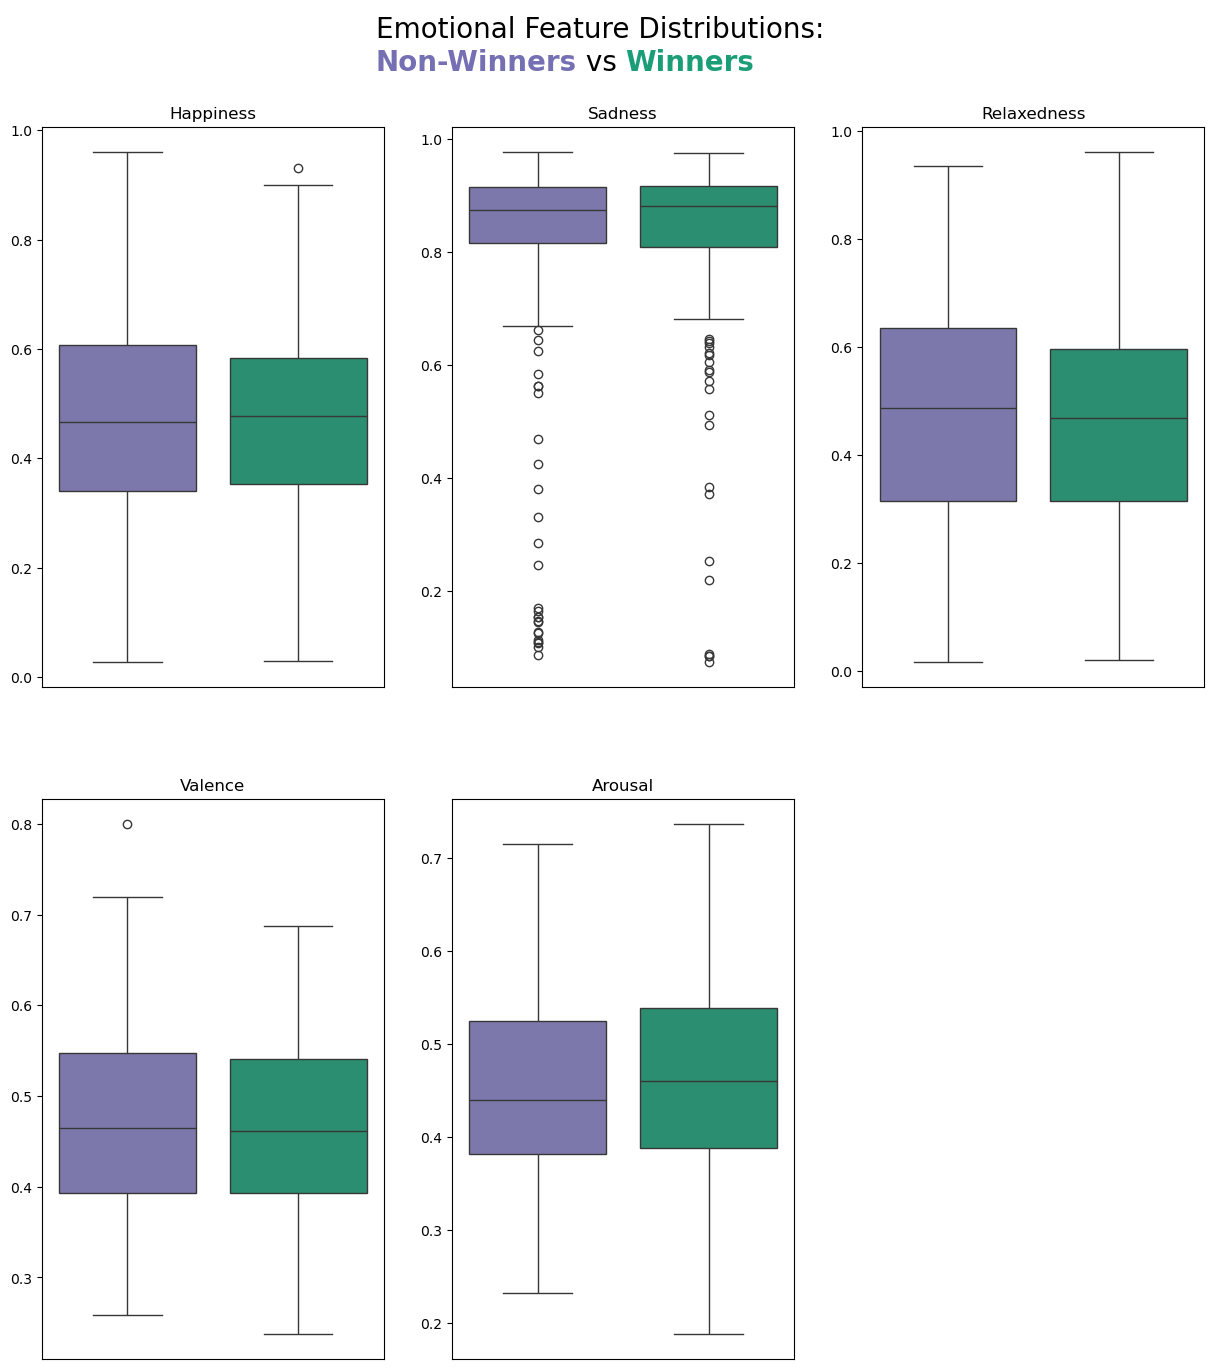


=== Emotional Features Analysis ===


,feature,statistic,p_value,significant,effect_size
0,Happiness,0.659648,0.5098,False,0.0617
1,Sadness,1.438220,0.1511,False,0.1346
2,Relaxedness,-0.238938,0.8113,False,0.0224
3,Valence,0.203369,0.8389,False,0.0190
4,Arousal,0.753327,0.4516,False,0.0705


In [10]:
# Analyze emotional features
emotional_df = create_feature_df(analysis_df, 'emotional')
plot_feature_distributions(emotional_df, FEATURE_GROUPS['emotional']['names'], 'Emotional Feature Distributions')
emotional_results = analyze_features(emotional_df, FEATURE_GROUPS['emotional']['names'], 'Emotional Features')
display(emotional_results)

## Analysis of Musical Features

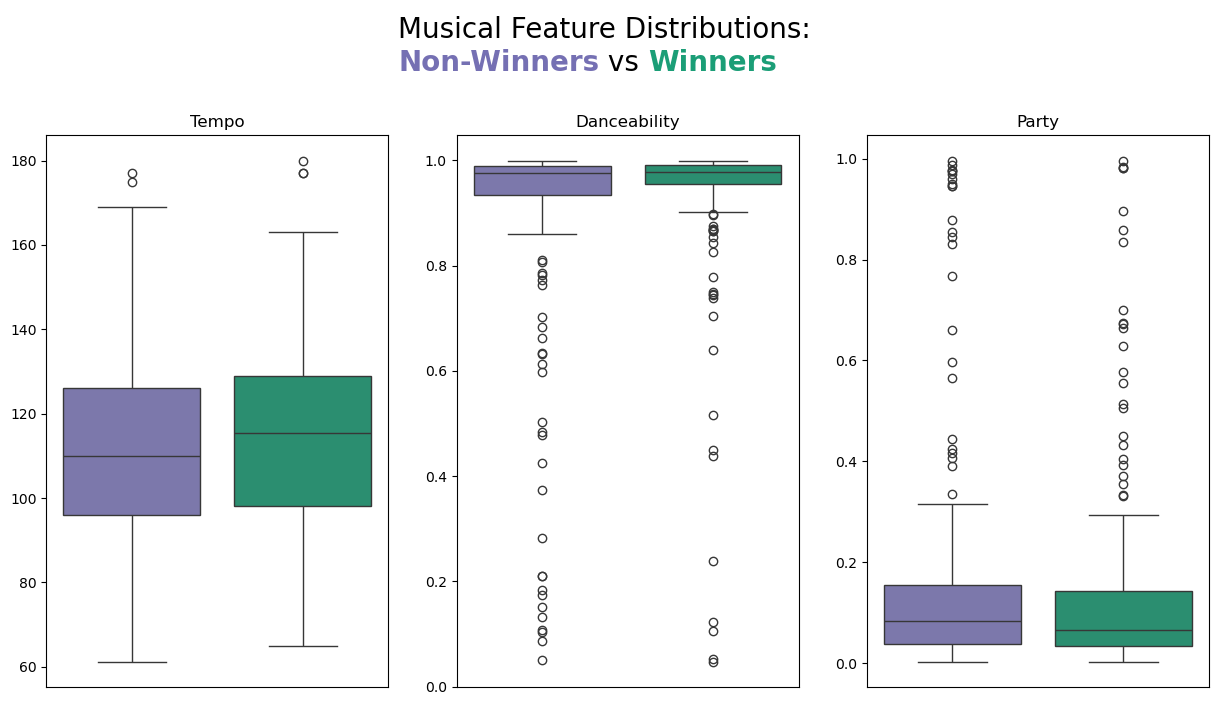


=== Musical Features Analysis ===


,feature,statistic,p_value,significant,effect_size
0,Tempo,1.231288,0.2189,False,0.1152
1,Danceability,2.109049,0.0355,True,0.1973
2,Party,-1.077682,0.2817,False,0.1008


In [11]:
# Analyze musical features
musical_df = create_feature_df(analysis_df, 'musical')
plot_feature_distributions(musical_df, FEATURE_GROUPS['musical']['names'], 'Musical Feature Distributions')
musical_results = analyze_features(musical_df, FEATURE_GROUPS['musical']['names'], 'Musical Features')
display(musical_results)

## Analysis of Production Features

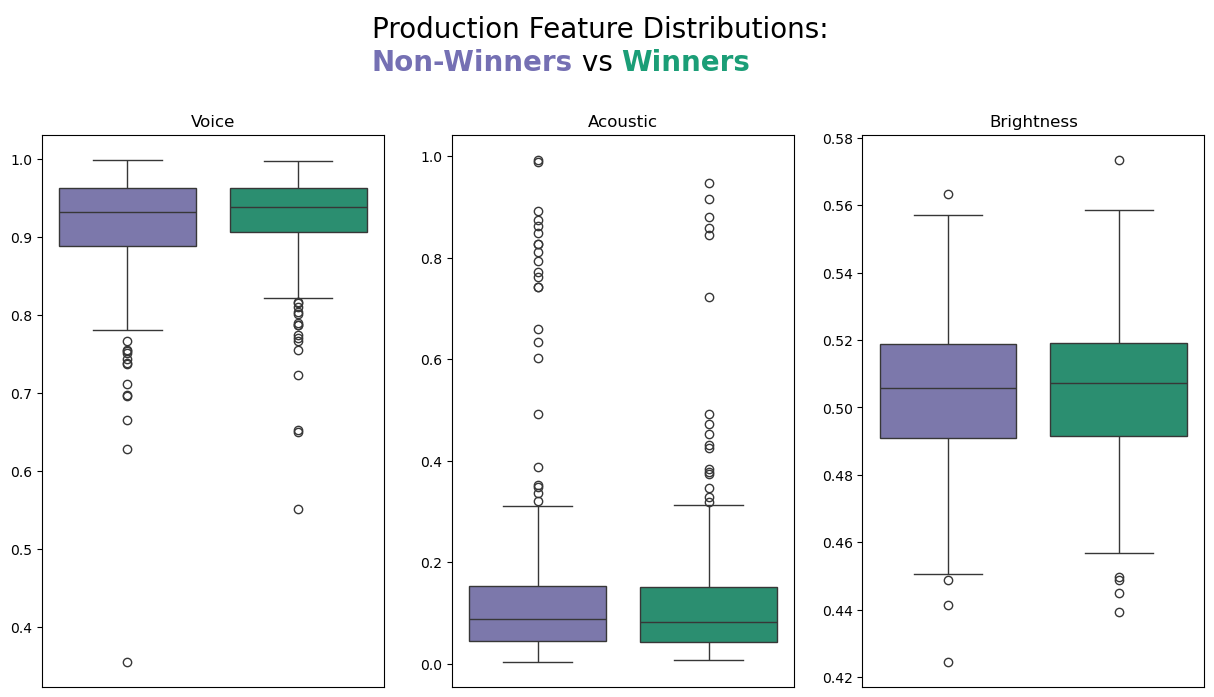


=== Production Features Analysis ===


,feature,statistic,p_value,significant,effect_size
0,Voice,1.481970,0.1390,False,0.1386
1,Acoustic,-1.629931,0.1038,False,0.1525
2,Brightness,0.148725,0.8818,False,0.0139


In [12]:
# Analyze production features
production_df = create_feature_df(analysis_df, 'production')
plot_feature_distributions(production_df, FEATURE_GROUPS['production']['names'], 'Production Feature Distributions')
production_results = analyze_features(production_df, FEATURE_GROUPS['production']['names'], 'Production Features')
display(production_results)

## Analysis of Engagement Features

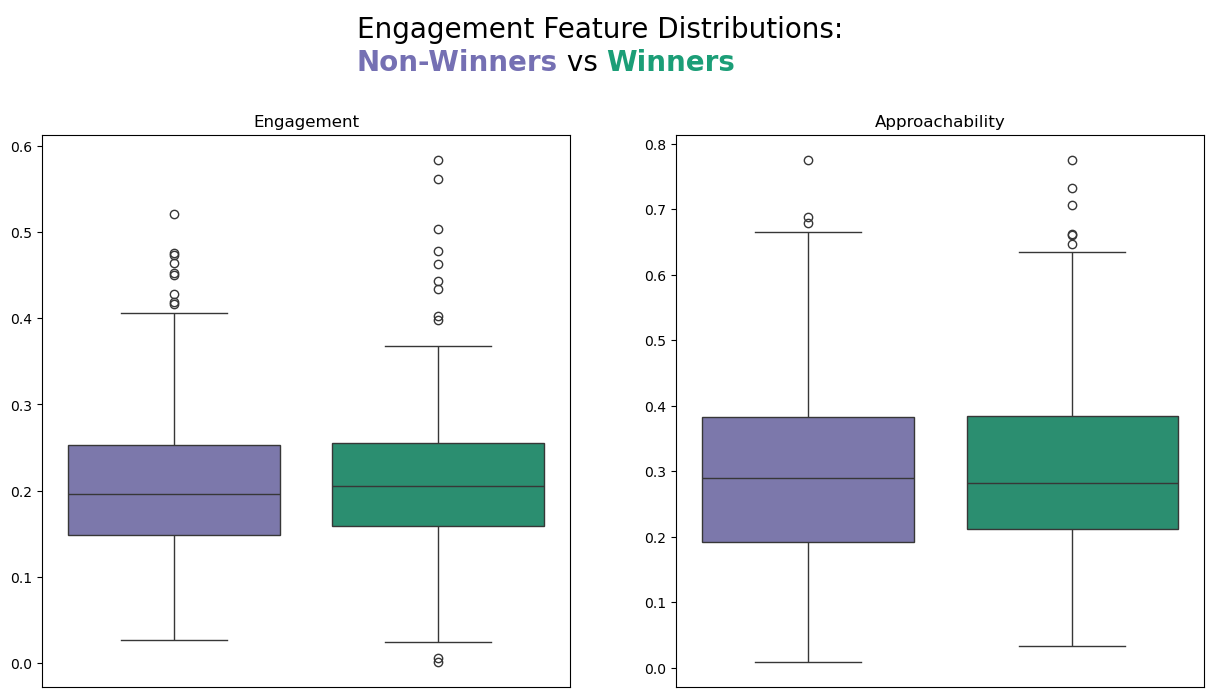


=== Engagement Features Analysis ===


,feature,statistic,p_value,significant,effect_size
0,Engagement,0.269722,0.7875,False,0.0252
1,Approachability,0.722324,0.4705,False,0.0676


In [13]:
# Analyze engagement features
engagement_df = create_feature_df(analysis_df, 'engagement')
plot_feature_distributions(engagement_df, FEATURE_GROUPS['engagement']['names'], 'Engagement Feature Distributions', ncols=2)
engagement_results = analyze_features(engagement_df, FEATURE_GROUPS['engagement']['names'], 'Engagement Features')
display(engagement_results)

# Further Analysis

## 1. Feature Correlations and Interactions
- Correlation matrix between all features
- Identify which features tend to occur together in winning songs
- Visualize feature relationships using heatmaps
- Study interaction effects between different feature groups

## 2. Temporal Analysis
- How have winning song characteristics changed over time?
- Are there trends in specific features across years?
- Seasonal patterns in winning characteristics

## 3. Genre-Based Analysis
- Distribution of genres among winners vs non-winners
- Feature patterns within specific genres
- Which genres have higher win rates?

## 4. Feature Importance and Predictive Modeling
- Random Forest feature importance
- Principal Component Analysis (PCA) for dimension reduction
- Build a basic predictive model for winning probability

## 5. Artist/Group Analysis
- Are there specific artists/groups with higher win rates?
- Do successful artists share common musical characteristics?
- Evolution of winning artists' musical features

## 6. Comprehensive Patterns
- Identify archetypal "winning song" profiles
- Cluster analysis to find natural groupings
- Combined feature analysis (e.g., high energy + high danceability)

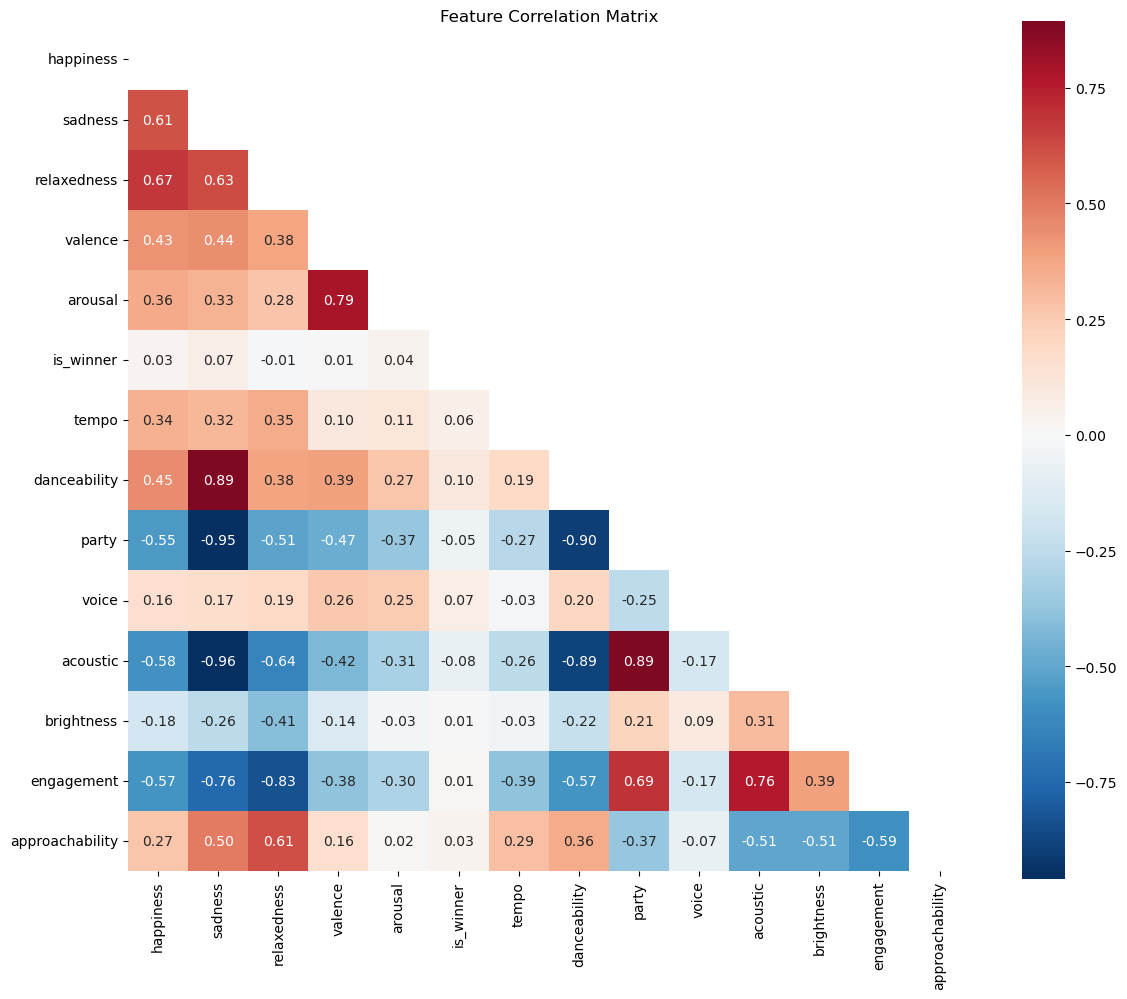


Strongest correlations with winning:
danceability       0.098394
voice              0.069309
sadness            0.067272
tempo              0.057628
arousal            0.035294
approachability    0.033844
happiness          0.030910
engagement         0.012644
valence            0.009534
brightness         0.006972
relaxedness       -0.011201
party             -0.050458
acoustic          -0.076190
Name: is_winner, dtype: float64


In [14]:
# Combine all features for correlation analysis
all_features = pd.DataFrame()

for group in FEATURE_GROUPS.keys():
    df = create_feature_df(analysis_df, group)
    if all_features.empty:
        all_features = df.to_pandas()
    else:
        # Exclude is_winner as it's already included
        all_features = pd.concat([all_features, df.drop('is_winner').to_pandas()], axis=1)

# Create correlation matrix
correlation_matrix = all_features.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt='.2f',
            square=True,
            mask=mask)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find strongest correlations with winning
win_correlations = correlation_matrix['is_winner'].sort_values(ascending=False)
print("\nStrongest correlations with winning:")
print(win_correlations[1:]) # Skips the comparison of winning

## Temporal Analysis

In [15]:
temporal_audio = all_awards.join(audio, left_on=["artist", "song"], right_on=["artist", "song_title"], how="inner")
temporal_audio = temporal_audio.with_columns(
    pl.when(pl.col("placement")==1).then(1).otherwise(0).alias("is_winner")
)

In [16]:
import matplotlib.dates as mdates
from matplotlib.patheffects import withStroke

def plot_temporal_trends(analysis_df, feature_group, title):
    """Plot temporal trends for a feature group."""
    # Convert to pandas for easier time series handling
    df = create_feature_df(analysis_df, feature_group).to_pandas()
    
    # Add and format date information
    df['date'] = analysis_df.select('date').to_pandas()
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    
    # Set color palette for features
    feature_colors = sns.color_palette("husl", len(FEATURE_GROUPS[feature_group]['names']))
    winner_styles = ['-', '--']  # solid for winners, dashed for non-winners
    
    # Create subplots
    fig, axes = plt.subplots(len(FEATURE_GROUPS[feature_group]['names']), 1, 
                            figsize=(15, 5*len(FEATURE_GROUPS[feature_group]['names'])))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    
    for idx, (feature, color) in enumerate(zip(FEATURE_GROUPS[feature_group]['names'], feature_colors)):
        # Calculate monthly averages
        winners_avg = df[df['is_winner'] == 1].groupby(pd.Grouper(key='date', freq='M'))[feature].mean()
        non_winners_avg = df[df['is_winner'] == 0].groupby(pd.Grouper(key='date', freq='M'))[feature].mean()
        
        # Plot trends with distinct styles
        axes[idx].plot(winners_avg.index, winners_avg.rolling(window=3).mean(),
                      label=f'Winners - {feature}', color=color, 
                      linestyle=winner_styles[0], linewidth=2)
        axes[idx].plot(non_winners_avg.index, non_winners_avg.rolling(window=3).mean(),
                      label=f'Non-Winners - {feature}', color=color, 
                      linestyle=winner_styles[1], linewidth=2)
        
        # Right after plotting both lines, replace the current annotation code with:
        # Get y-axis limits to place annotations properly
        y_min, y_max = axes[idx].get_ylim()
        annotation_space = (y_max - y_min) * 0.1  # 10% of y-axis range for spacing

        # Add annotations with consistent positioning
        axes[idx].annotate('─── Winners', 
                        xy=(0.02, 0.95), 
                        xycoords='axes fraction',
                        color=color, 
                        fontweight='bold', 
                        fontsize=10,
                        va='center')
        axes[idx].annotate('- - - Non-Winners', 
                        xy=(0.02, 0.89), 
                        xycoords='axes fraction',
                        color=color, 
                        fontweight='bold', 
                        fontsize=10,
                        va='center',
                        path_effects=[withStroke(linewidth=3, foreground='white')])
        
        # Format x-axis
        axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        
        # Customize appearance
        axes[idx].set_title(f'{feature.capitalize()}', fontsize=12, pad=10)
        # axes[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylabel('Value')
    
    # Add overall title
    plt.suptitle(title, y=1.02, fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return analyze_seasonality(df, FEATURE_GROUPS[feature_group]['names'])

def analyze_seasonality(df, features):
    """Analyze seasonal patterns in features."""
    seasonal_patterns = pd.DataFrame()
    
    # Get the same color palette as temporal trends
    feature_colors = sns.color_palette("husl", len(features))
    winner_styles = ['-', '--']  # solid for winners, dashed for non-winners
    
    for feature in features:
        monthly_avg = df.groupby(['month', 'is_winner'])[feature].mean().unstack()
        seasonal_patterns[f'{feature}_winners'] = monthly_avg[1]
        seasonal_patterns[f'{feature}_non_winners'] = monthly_avg[0]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot each feature with consistent colors
    for idx, feature in enumerate(features):
        # Plot winners (solid line)
        plt.plot(range(1, 13), seasonal_patterns[f'{feature}_winners'],
                color=feature_colors[idx], linestyle=winner_styles[0],
                linewidth=2, label=f'{feature.capitalize()}')
        
        # Plot non-winners (dashed line)
        plt.plot(range(1, 13), seasonal_patterns[f'{feature}_non_winners'],
                color=feature_colors[idx], linestyle=winner_styles[1],
                linewidth=2)
        
        # Add direct labels at the end of lines
        last_winner = seasonal_patterns[f'{feature}_winners'].iloc[-1]
        last_non_winner = seasonal_patterns[f'{feature}_non_winners'].iloc[-1]
        
        plt.annotate(feature.capitalize(), 
                    xy=(12, last_winner),
                    xytext=(12.1, last_winner),
                    color=feature_colors[idx],
                    fontweight='bold')
    
    # Customize appearance
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3)
    plt.xlabel('Month')
    plt.ylabel('Average Value')
    
    # Remove legend since we're using direct labels
    plt.xlim(1, 13.5)  # Extend x-axis slightly for labels
    plt.tight_layout()
    
    return seasonal_patterns


=== Temporal Analysis: Emotional Features ===


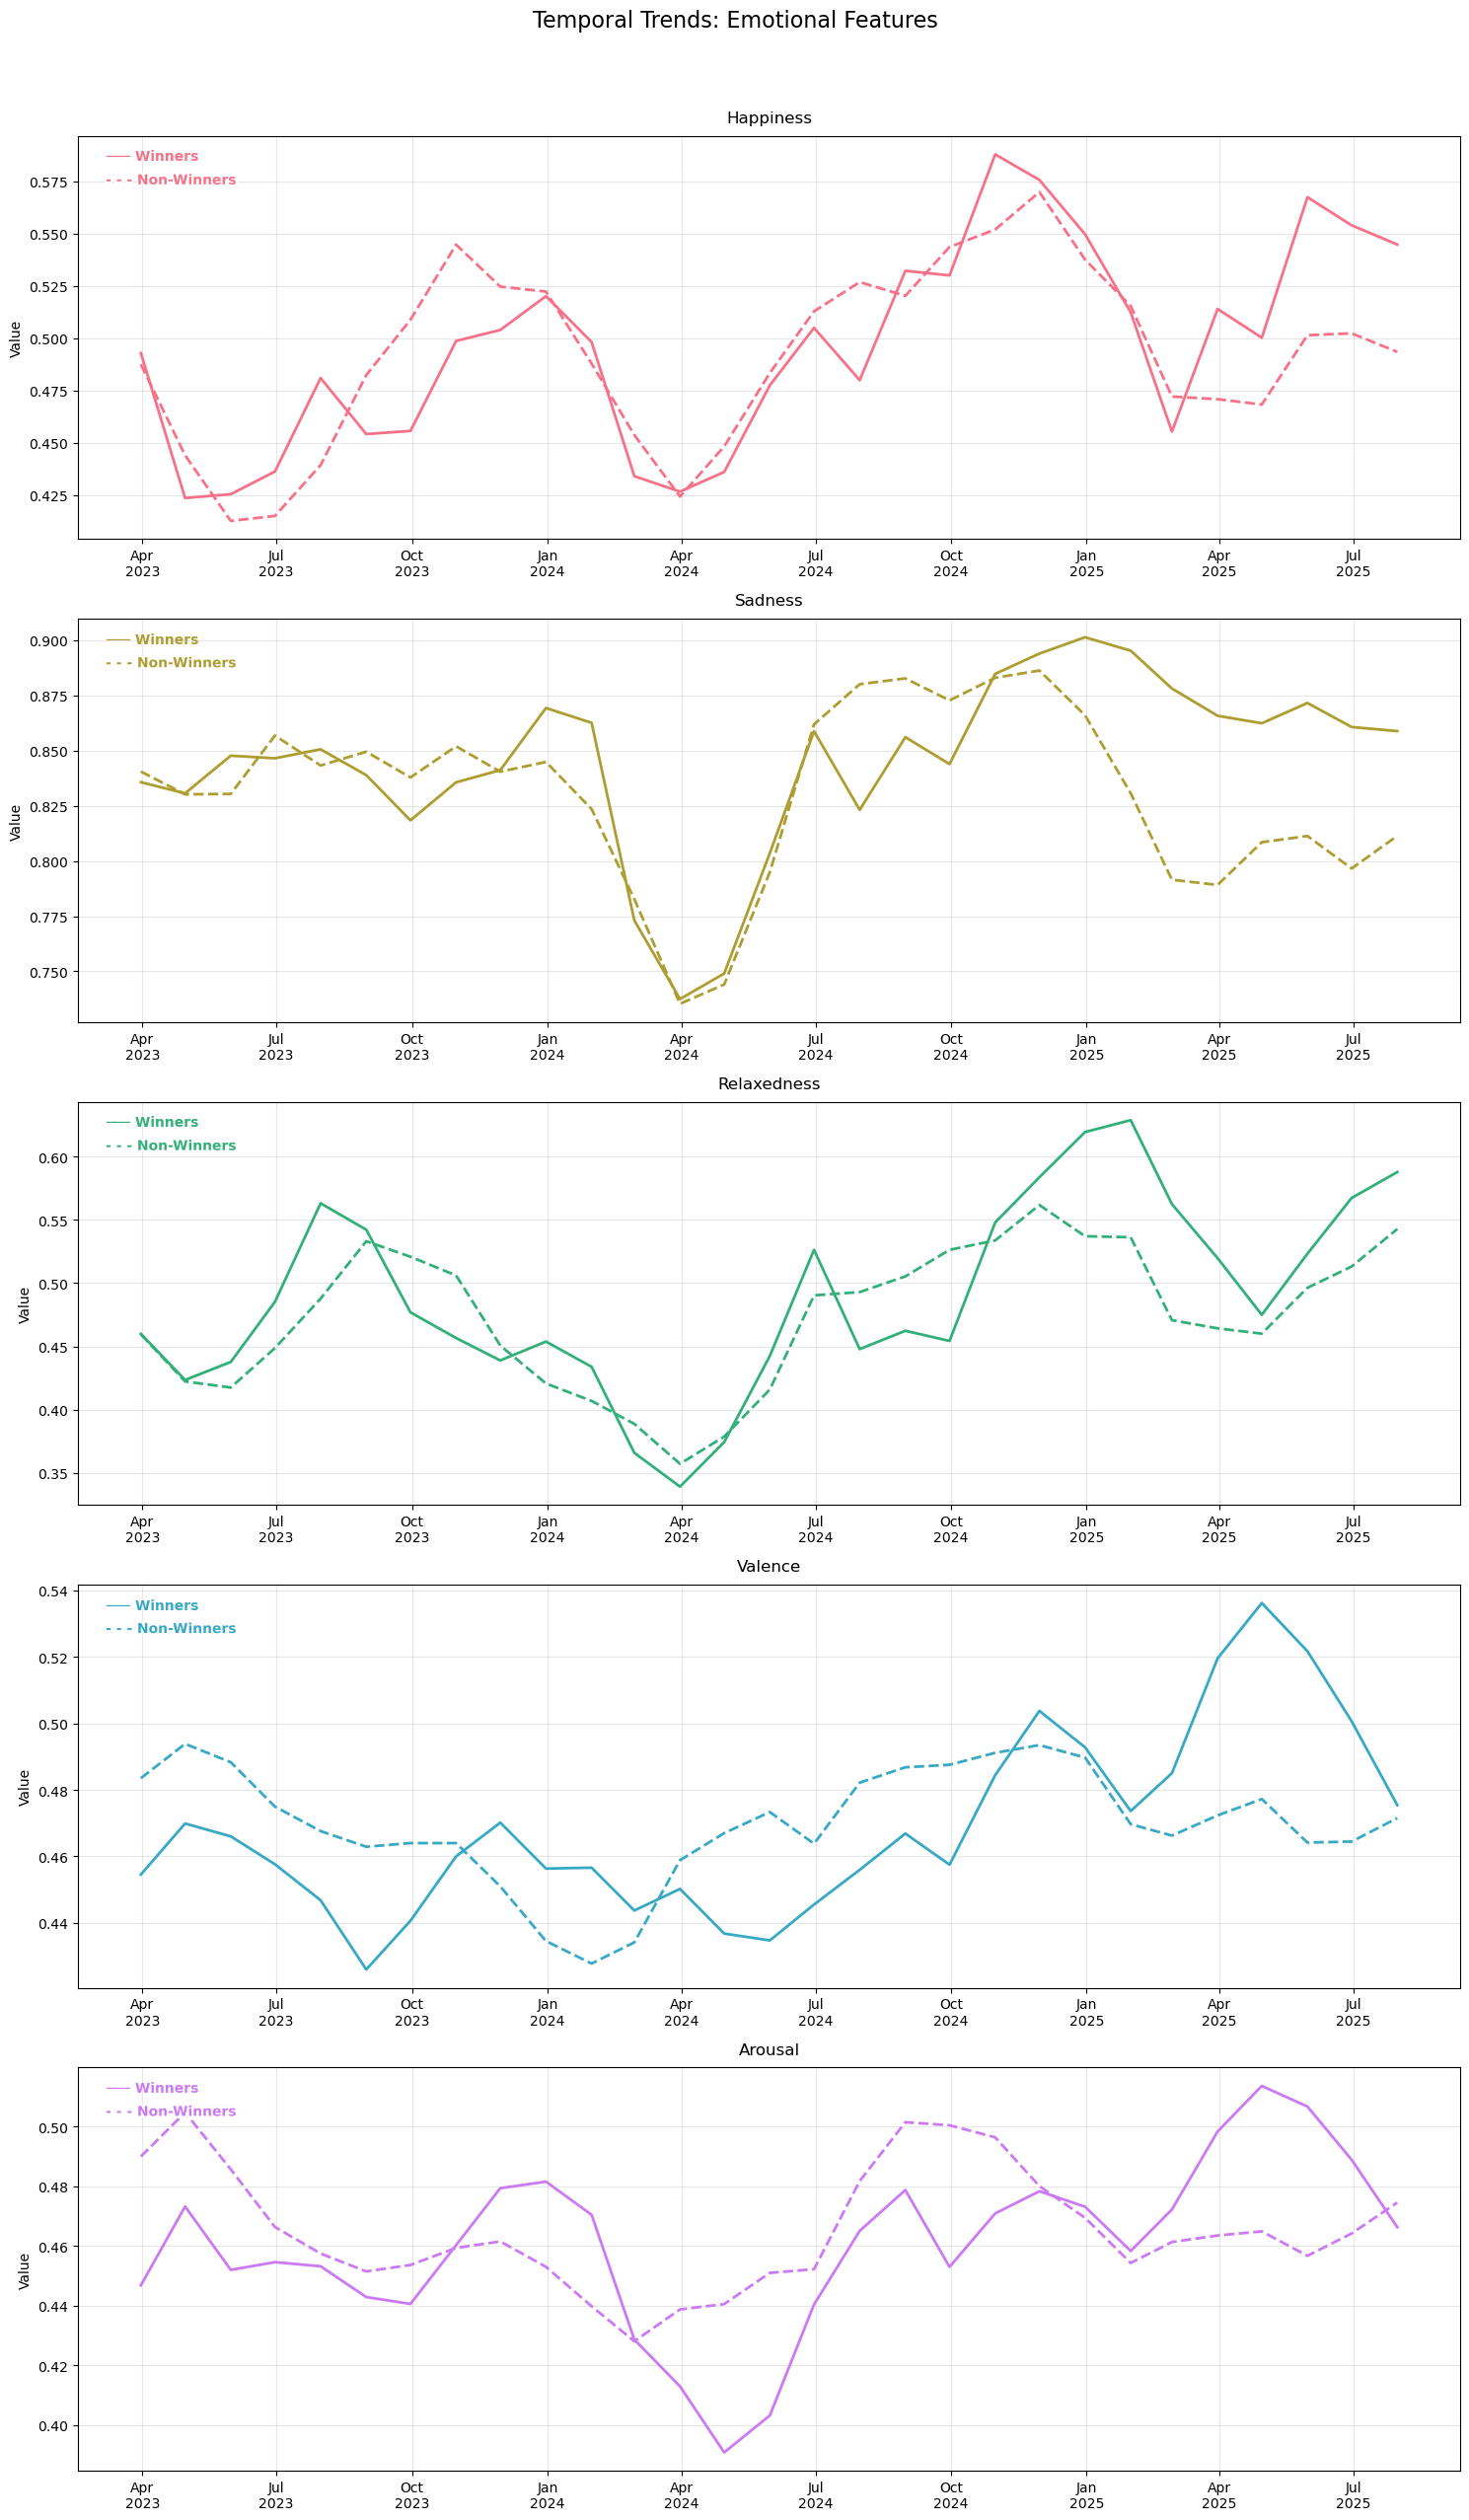

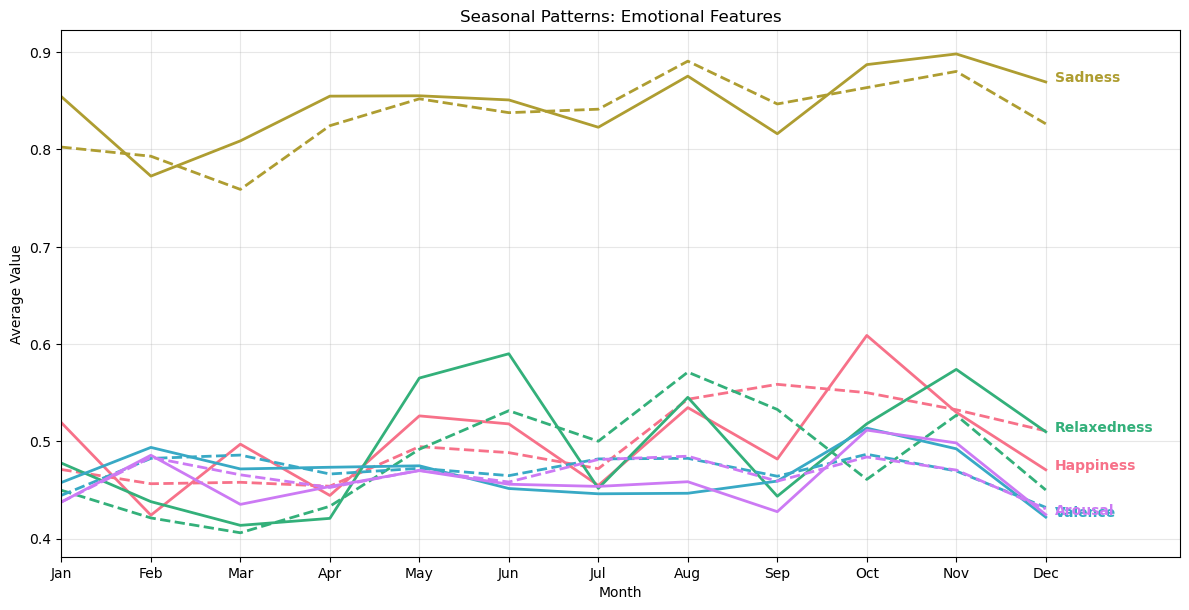


=== Temporal Analysis: Musical Features ===


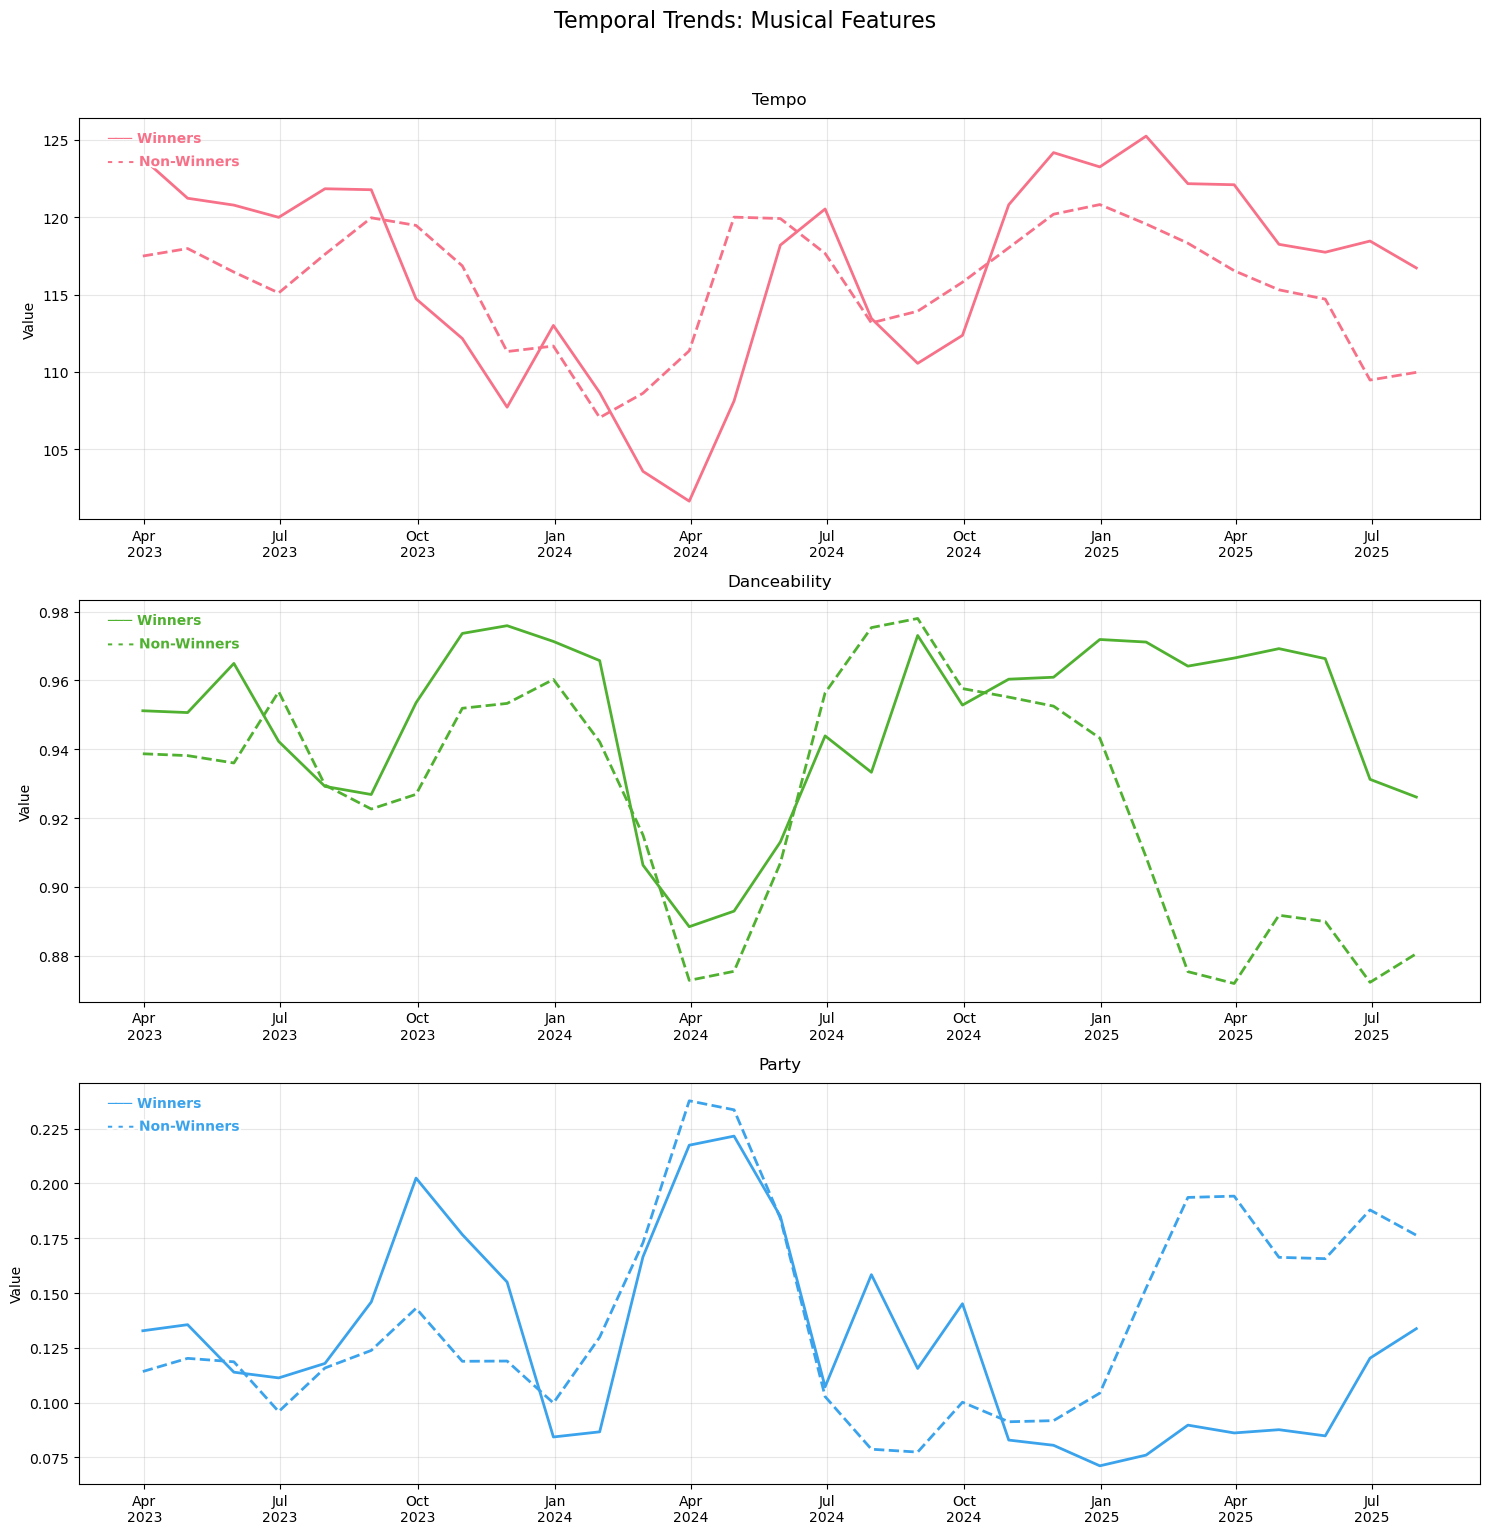

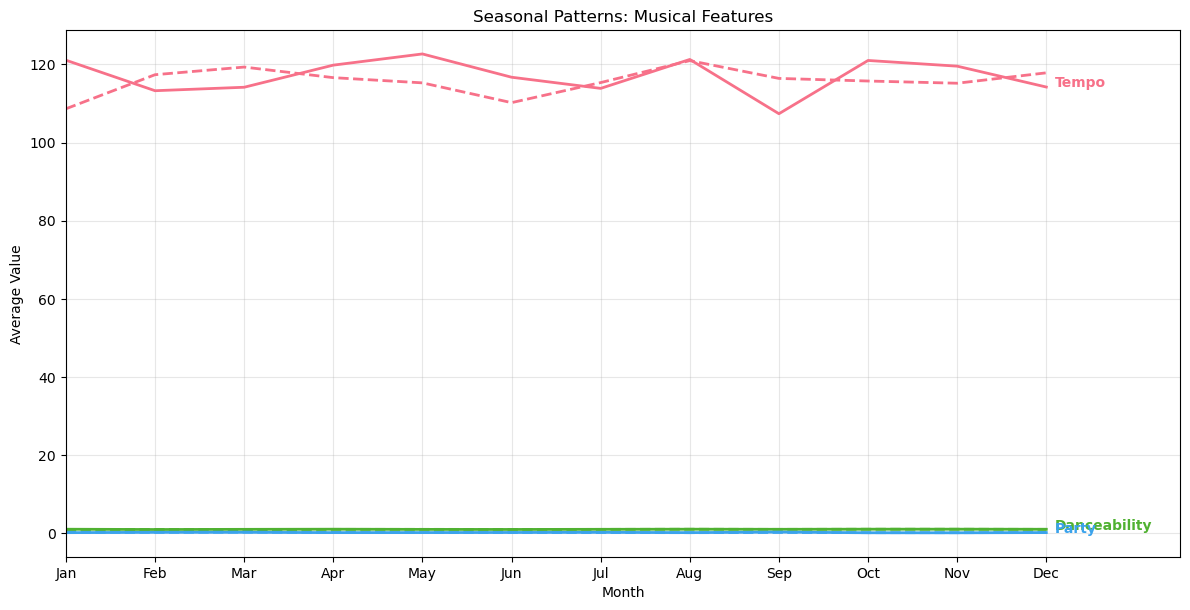


=== Temporal Analysis: Production Features ===


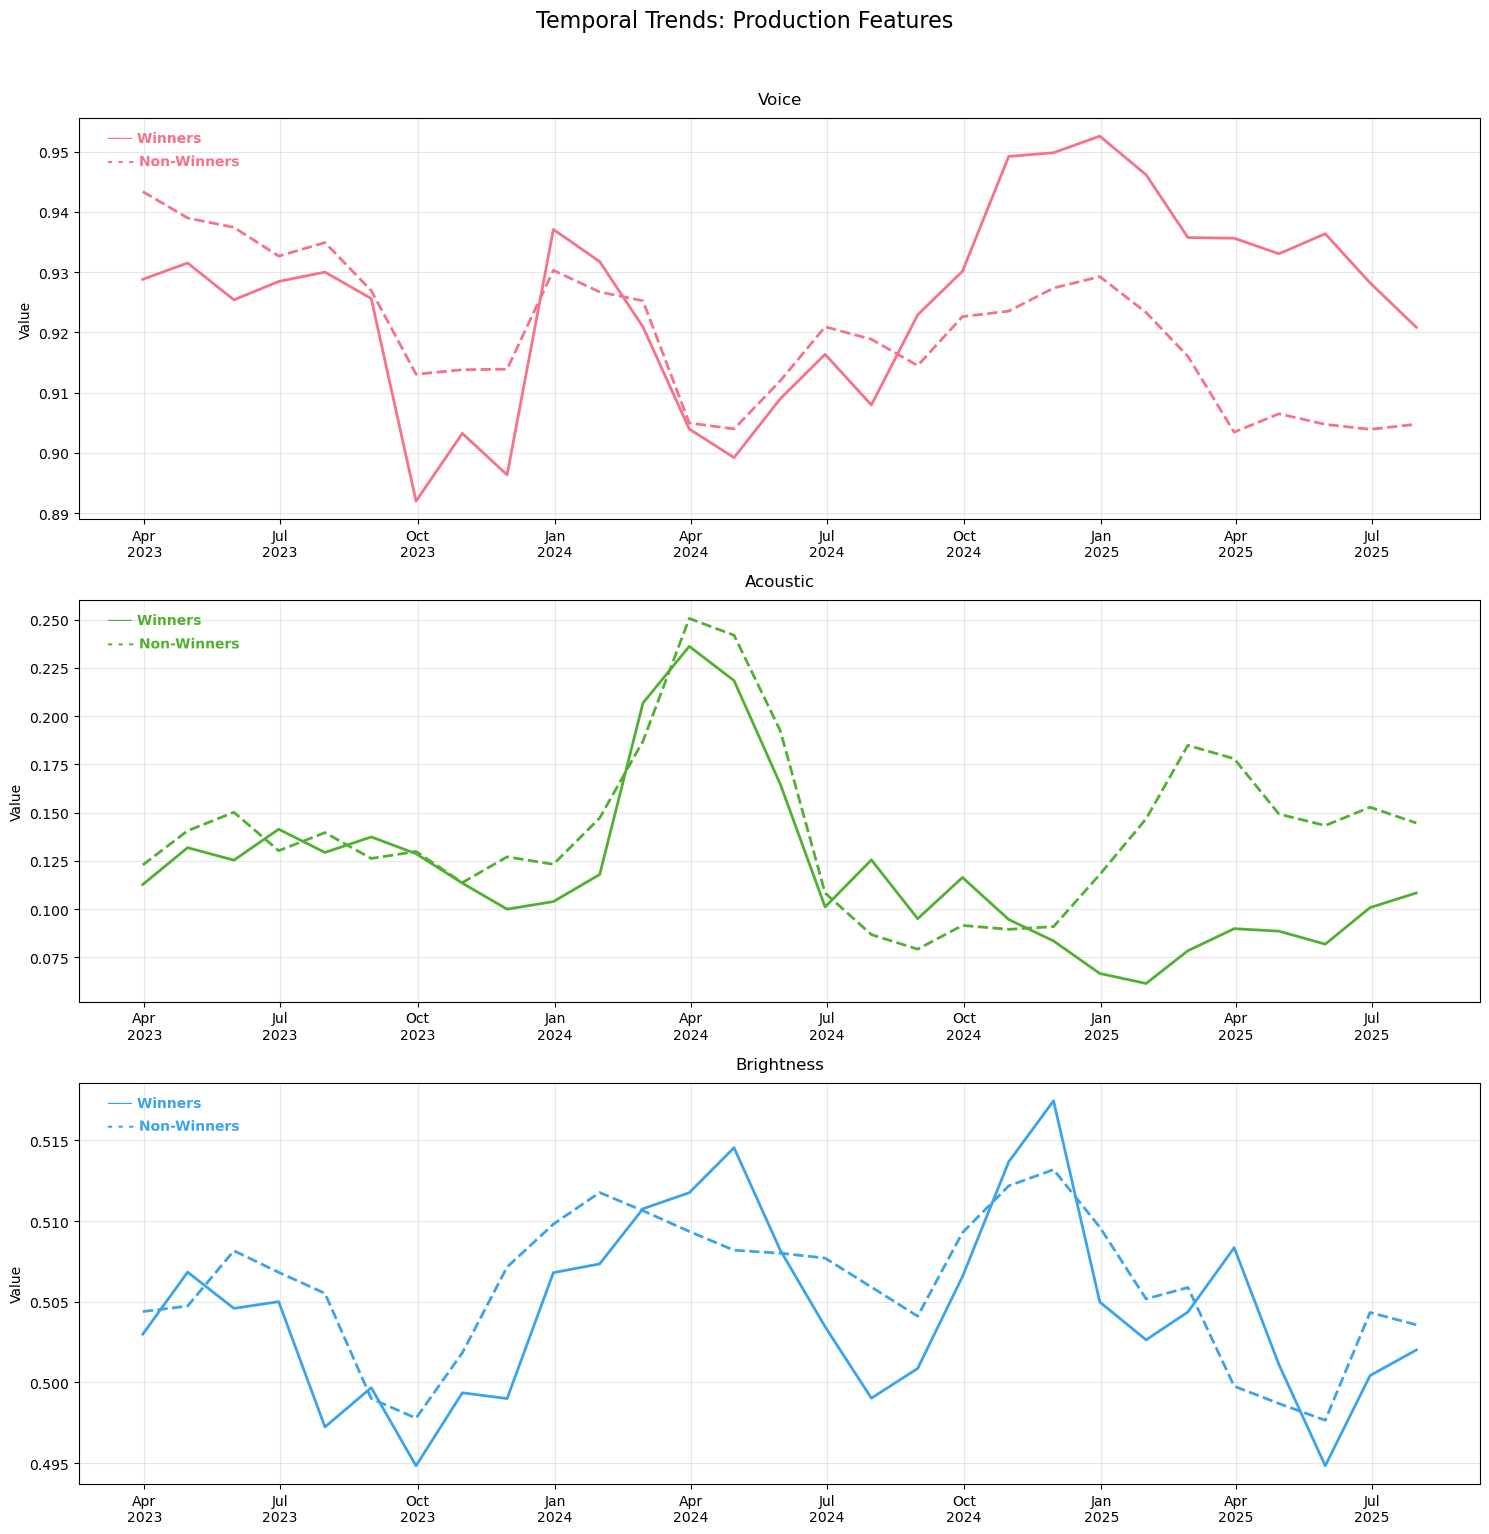

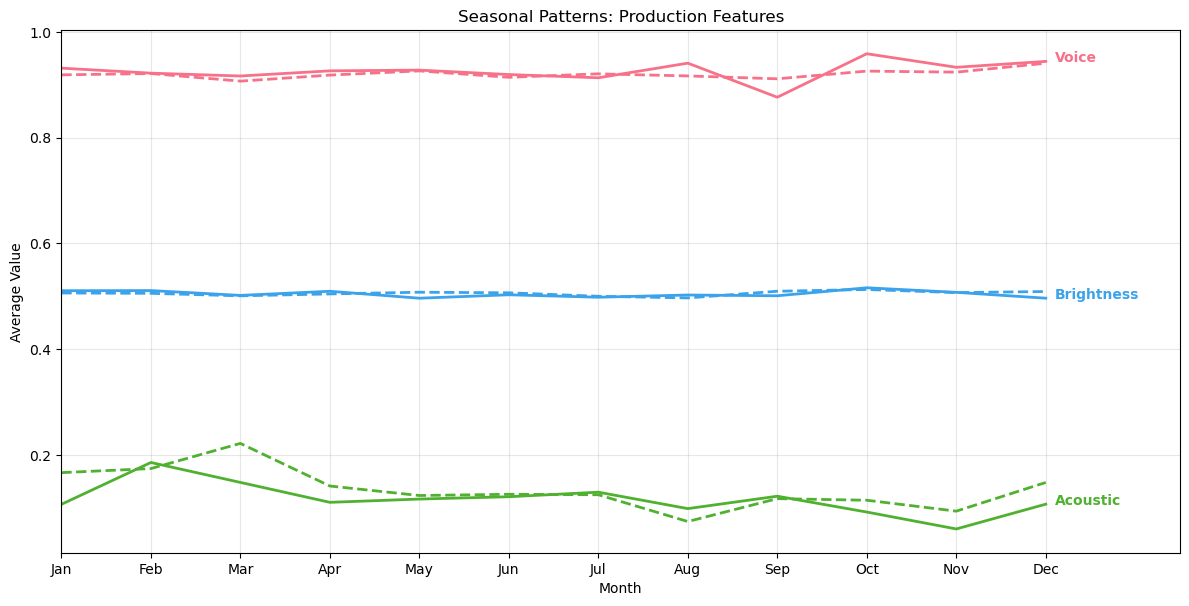


=== Temporal Analysis: Engagement Features ===


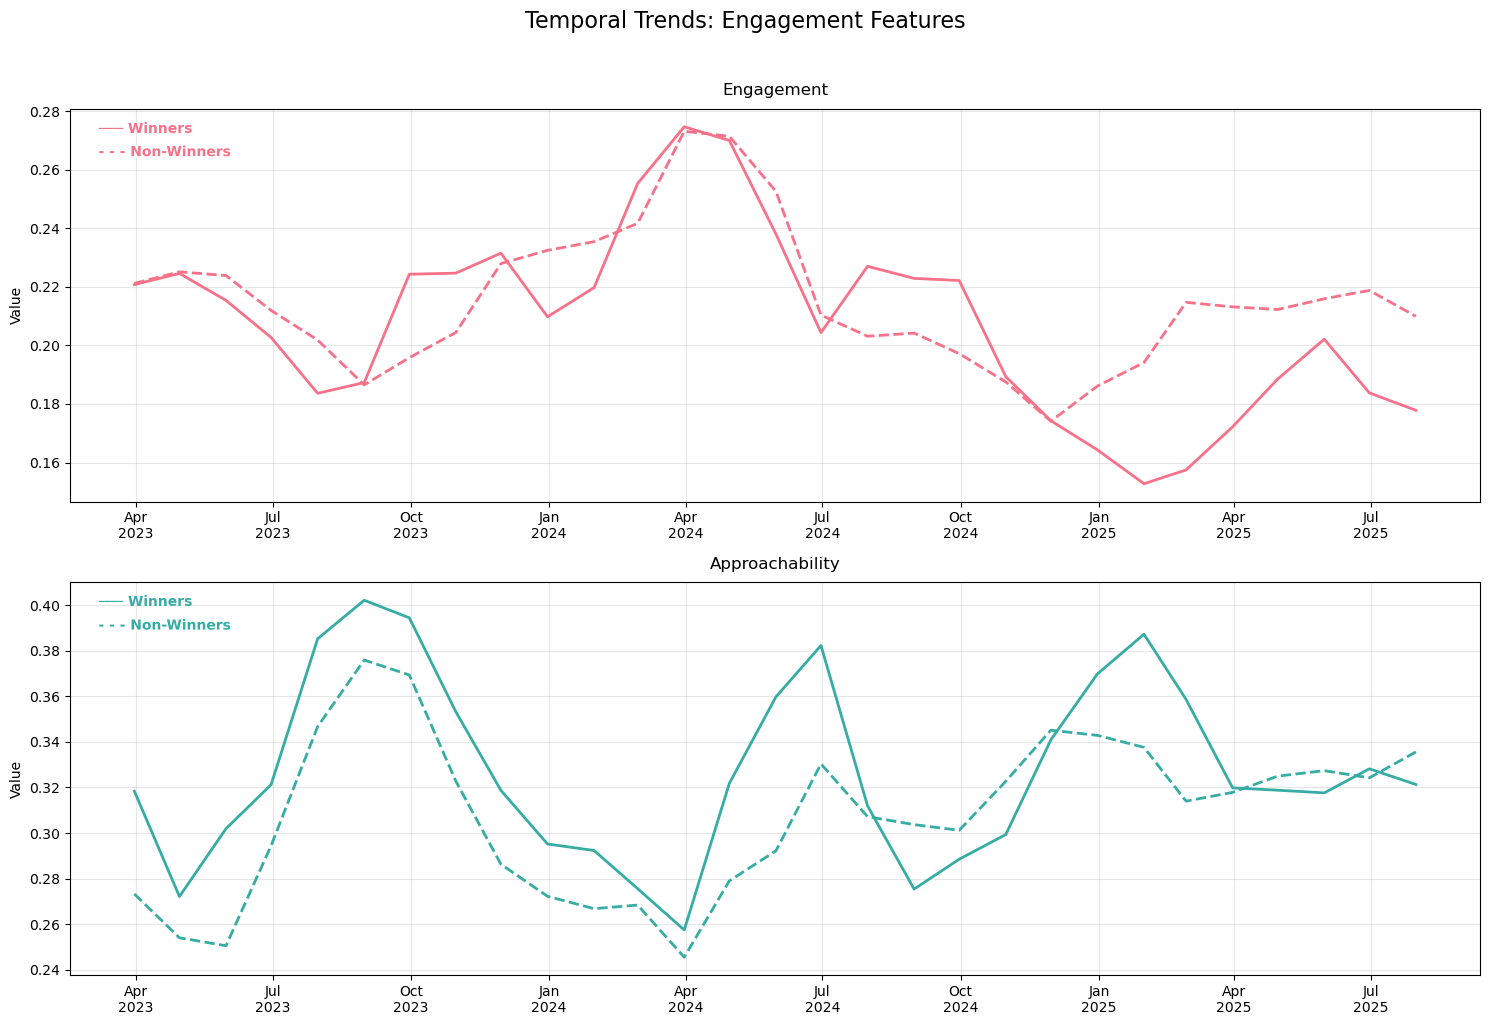

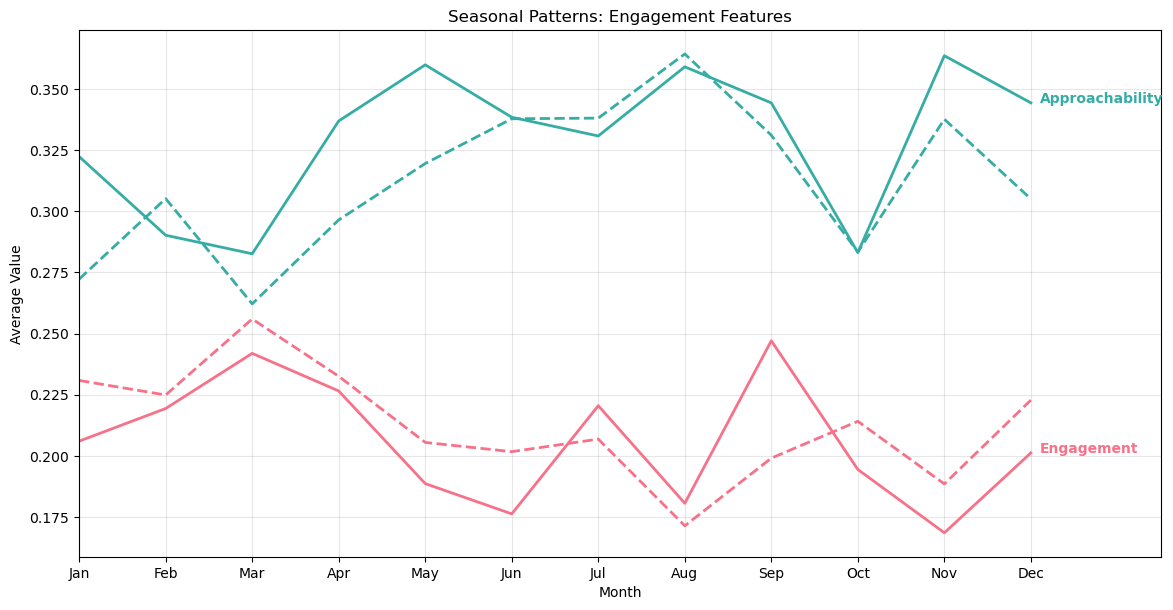

In [17]:
# Analyze temporal patterns for each feature group
for group in FEATURE_GROUPS.keys():
    print(f"\n=== Temporal Analysis: {group.capitalize()} Features ===")
    
    seasonal_patterns = plot_temporal_trends(
        temporal_audio, 
        group, 
        f'Temporal Trends: {group.capitalize()} Features'
    )
    
    plt.title(f'Seasonal Patterns: {group.capitalize()} Features')
    plt.xlabel('Month')
    plt.ylabel('Average Value')
    plt.grid(True, alpha=0.3)
    plt.show()

## Genre-based Analysis

In [23]:
genre_df = analysis_df[['artist', 'song', 'audio_features__genre__top_1_class', 'audio_features__genre__top_2_class', 'audio_features__genre__top_3_class', 'is_winner']]
genre_df = genre_df.rename({'audio_features__genre__top_1_class': 'genre_1st', 'audio_features__genre__top_2_class': 'genre_2nd', 'audio_features__genre__top_3_class': 'genre_3rd'})

In [ ]:
genre_df['genre_1st'].value_counts().top_k(5, by='count')
genre_df['genre_1st'].filt

genre_1st,count
str,u32
"""Pop---K-pop""",338
"""Hip Hop---Trap""",18
"""Electronic---House""",17
"""Latin---Reggaeton""",14
"""Electronic---Dance-pop""",10


In [284]:
def analyze_genre_distributions(genre_df, top_n=10, title="Primary", genre_col="genre_1st"):
    top_genres = list(
        genre_df[genre_col]
        .value_counts()
        .top_k(top_n, by='count')[genre_col]
    )

    filtered_df = genre_df.filter(genre_df[genre_col].is_in(top_genres))

    plt.figure(figsize=(12, 6))

    sns.countplot(data=filtered_df,
                  y=genre_col,
                  hue='is_winner',
                  order=top_genres,
                  palette=["#7570B3", "#1B9E77"],
                  legend=False
                  )
    fig_text(
        s=f'Distribution of {title} Genres: <Non-Winners> vs <Winners>',
        x=0.4, y=.95,
        fontsize=16,
        color='black',
        highlight_textprops=[
            {"color": "#7570B3", 'fontweight': 'bold'},
            {"color": "#1B9E77", 'fontweight': 'bold'}
        ],
        ha='center'
    )
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(ylabel=None, xlabel=None)
    
    plt.show()

def analyze_genre_win_rates(genre_df, top_n=10, genre_col='genre_1st', title='Primary'):
    # Calculate win rates per genre
    win_rates = (genre_df.group_by(genre_col)
                        .agg([
                            pl.count('is_winner').alias('count'),
                            pl.mean('is_winner').alias('mean')
                        ])
                        .top_k(top_n, by='mean'))
    
    # Plot win rates (convert to pandas for Matplotlib compatibility)
    win_rates_pd = win_rates.to_pandas()

    # Conditional Coloring
    win_rates_pd["color"] = np.where(
        win_rates_pd["mean"] >= 0.5, "#1B9E77", "#7570B3"
    )
    palette = dict(zip(win_rates_pd[genre_col], win_rates_pd["color"]))
    plt.figure(figsize=(12, 6))
    sns.barplot(data=win_rates_pd,
                  y=genre_col,
                  x='mean',
                  hue=genre_col,
                  palette=palette)

    # Annotate with counts
    for i, (count, mean) in enumerate(zip(win_rates_pd["count"], win_rates_pd["mean"])):
        plt.gca().text(
            mean + 0.002, i,  # position slightly above bar
            str(count),
            ha="left", va="center", fontsize=9
        )

    plt.title(f"Win Rate by {title} Genre")
    plt.xlabel("Genre")
    plt.ylabel("Win Rate")

    ax = plt.gca()
    ax.tick_params(left=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(ylabel=None, xlabel=None)
    
    plt.show()

    return win_rates

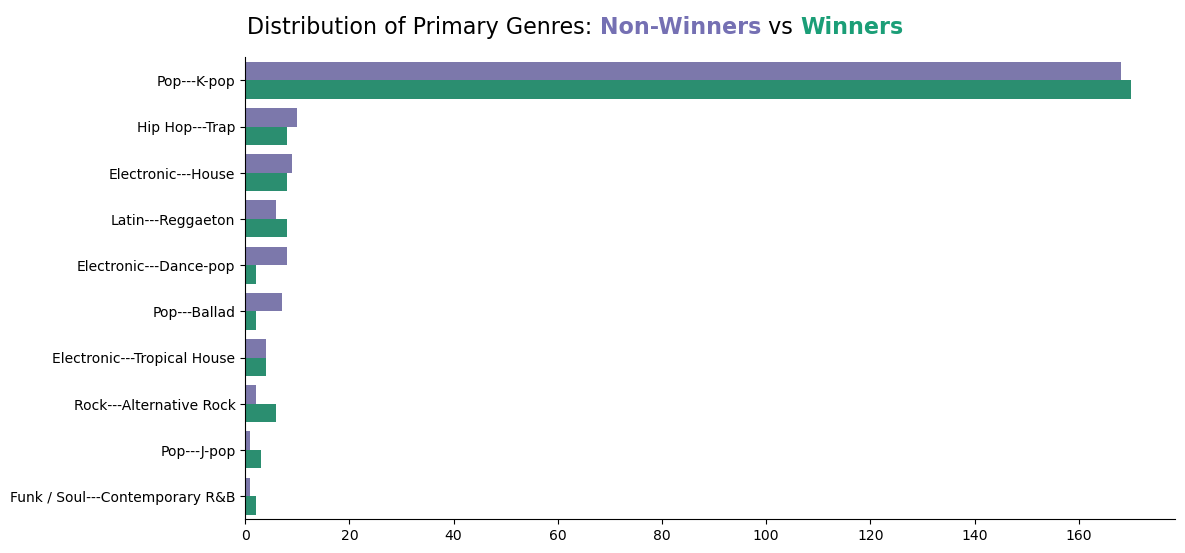

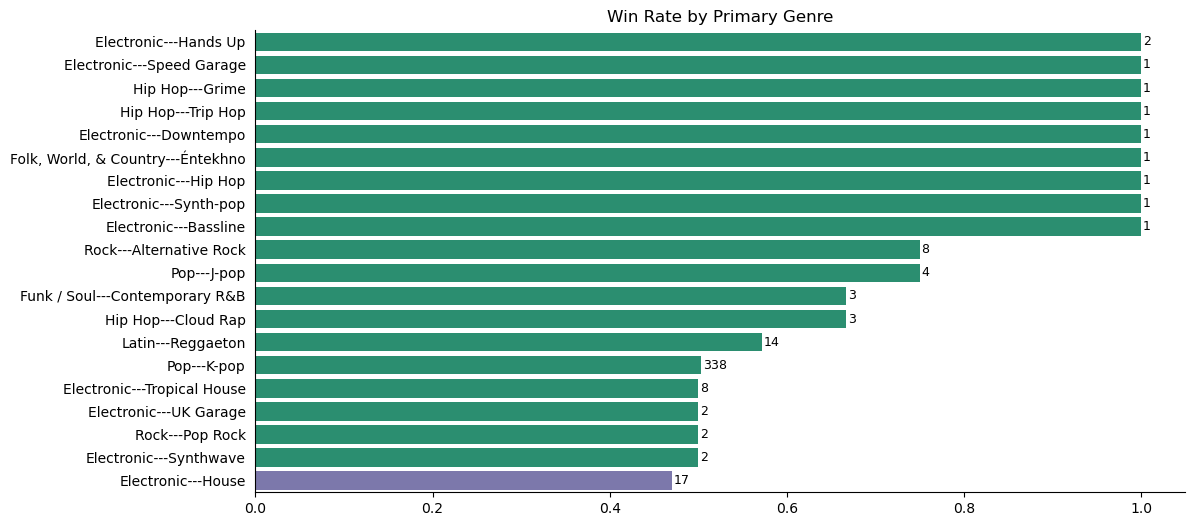

In [291]:
analyze_genre_distributions(genre_df, title="Primary", genre_col='genre_1st')
analyze_genre_win_rates(genre_df, title="Primary", genre_col='genre_1st', top_n=20);

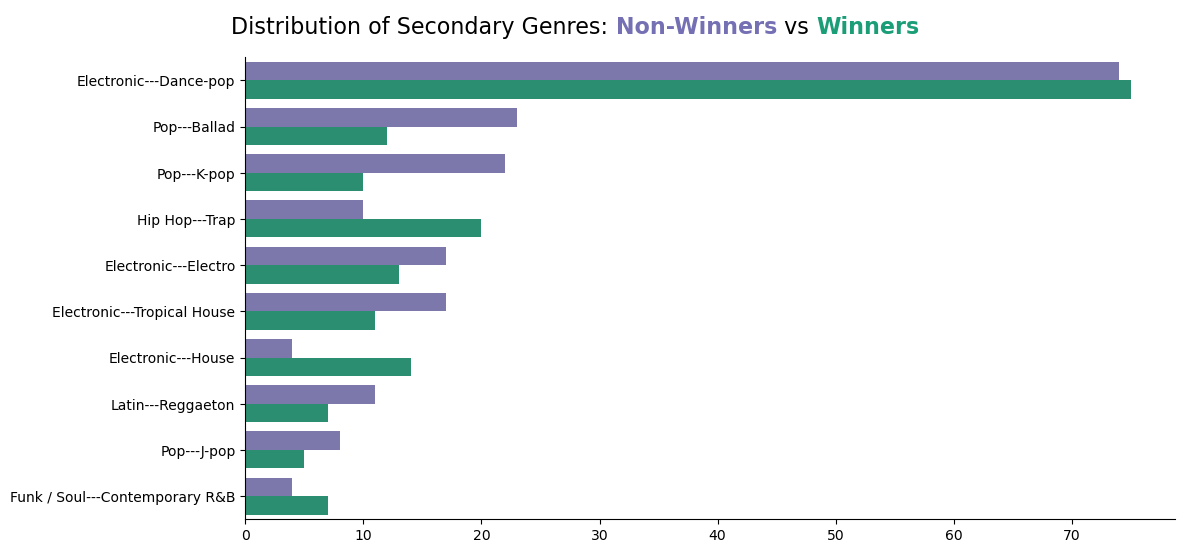

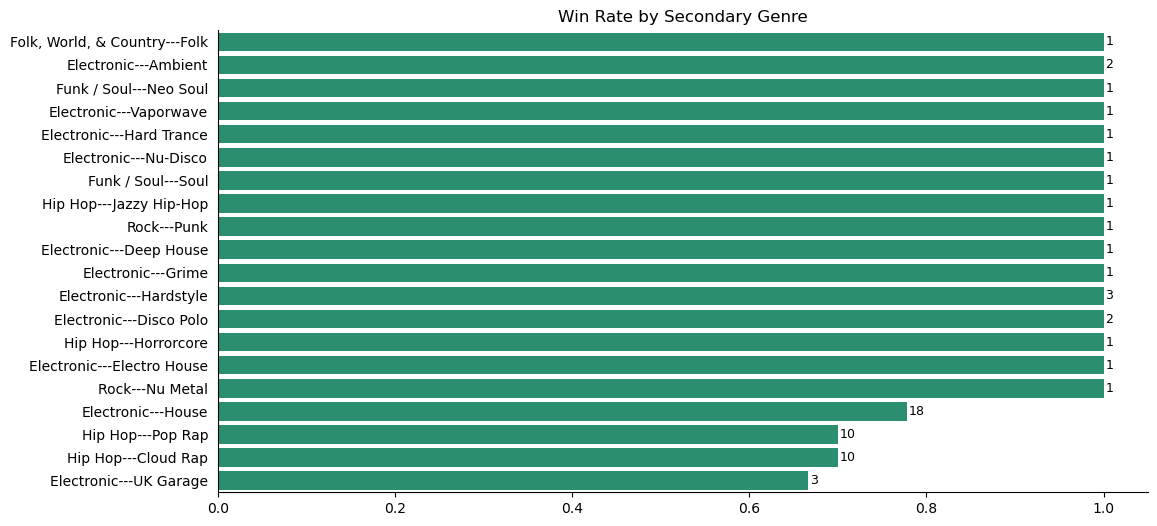

In [290]:
analyze_genre_distributions(genre_df, title="Secondary", genre_col='genre_2nd')
analyze_genre_win_rates(genre_df, title="Secondary", genre_col='genre_2nd', top_n=20);

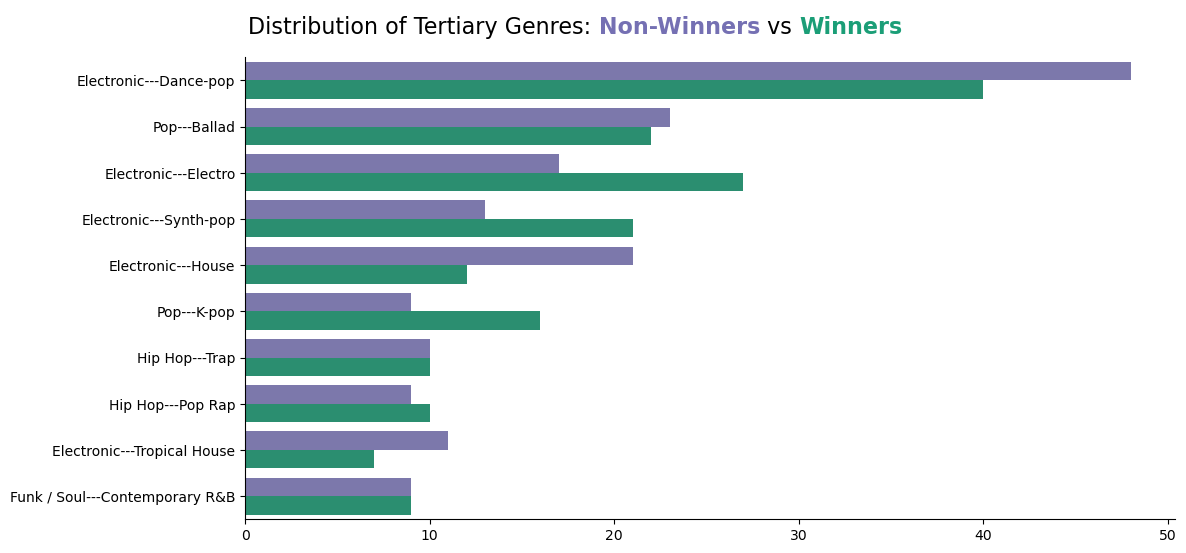

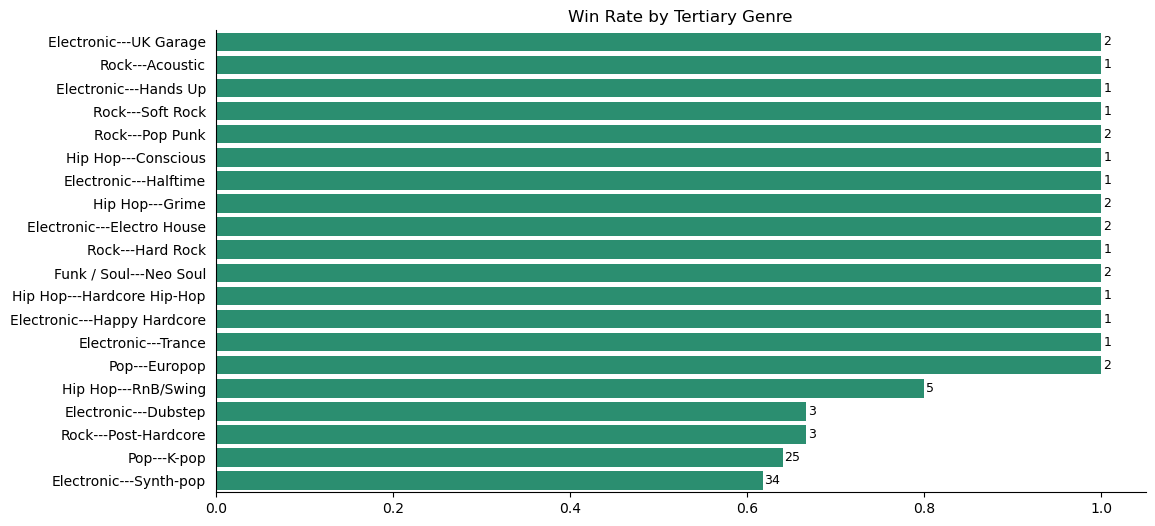

In [289]:
analyze_genre_distributions(genre_df, title="Tertiary", genre_col='genre_3rd')
analyze_genre_win_rates(genre_df, title="Tertiary", genre_col='genre_3rd', top_n=20);